In [1]:
import importlib as imp
import spotiphy
import numpy as np
import scanpy as sc
import squidpy as sq
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import spotiphy
import seaborn as sns

In [2]:
adata_st = sc.read_h5ad("results/Xenium/adata_st.h5ad")
type_list = adata_st.uns['type_list']
results_folder = 'results/Xenium/'
data_folder = 'results/Xenium/deconvolution/'
type_list_RCTD = [s.replace('/', '') for s in type_list]
type_list_RCTD = [s.replace(' ', '.') for s in type_list_RCTD]

In [3]:
cell_count_truth = adata_st.obs[type_list].to_numpy()+1e-5
proportion_truth = cell_count_truth/np.sum(cell_count_truth, axis=1, keepdims=True)
proportion_spotiphy = np.load(data_folder+'proportion_Sp.npy')
proportion_tangram = np.load(data_folder+'proportion_Tg.npy')
proportion_c2l = np.load(data_folder+'proportion_c2l.npy')
proportion_CARD = pd.read_csv(data_folder+'Proportion_CARD.csv', index_col=0, header=0)
proportion_CARD = proportion_CARD.reindex(adata_st.obs_names)
proportion_CARD = proportion_CARD[type_list].values
proportion_CARD = np.nan_to_num(proportion_CARD)
proportion_cyto = pd.read_csv(data_folder+'Proportion_Cyto.csv', index_col=0, header=0)
proportion_cyto = proportion_cyto.reindex(adata_st.obs_names)
proportion_cyto = proportion_cyto[type_list].values
proportion_RCTD = pd.read_csv(data_folder+'Proportion_RCTD.csv', index_col=0, header=0)
proportion_RCTD = proportion_RCTD.reindex(adata_st.obs_names)
proportion_RCTD = proportion_RCTD[type_list_RCTD].values

methods = ['Spotiphy', 'Tangram', 'Cell2location', 'CARD', 'CytoSPACE', 'RCTD']
proportion_estimated = [proportion_spotiphy, proportion_tangram, proportion_c2l, proportion_CARD, proportion_cyto, proportion_RCTD]
proportion_dict = {k:v for k, v in zip(methods, proportion_estimated)}

In [4]:
adata_st.uns['spatial']['NCF221-D']['scalefactors']['tissue_hires_crop_scalef'] = 0.2
img = adata_st.uns['spatial']['NCF221-D']['images']['hires']
crop_coord = [1500, 4300, 1250, 8650]
crop_coord_he = [255, 1246, 250, 815]

mask = np.zeros_like(img)
mask[crop_coord_he[0]:crop_coord_he[1], crop_coord_he[2]:crop_coord_he[3]] = 1
for i in range(crop_coord_he[0], crop_coord_he[1]):
    for j in range(crop_coord_he[2], crop_coord_he[3]):
        if i*0.3 + j >= crop_coord_he[0]*0.3 + crop_coord_he[3]:
            mask[i, j] = 0
for i in range(1000, len(mask)):
    for j in range(crop_coord_he[2], crop_coord_he[3]):
        if (1200-i)*0.22 + j <= 570 :
            mask[i, j] = 1

img = img * mask
diff = np.sum(np.abs(img-np.array([0.92156863, 0.92156863, 0.92941177, 1.])), axis=2)
img[diff<0.1] = [0, 0, 0, 0]
adata_st.uns['spatial']['NCF221-D']['images']['hires_crop'] = img

In [5]:
Xenium_img = np.load('results/Xenium/Xenium_resize_Affine.npy')
crop_coord_xe = [1275, 6230, 1250, 4075]
mask = np.zeros_like(Xenium_img)
mask[crop_coord_xe[0]:crop_coord_xe[1], crop_coord_xe[2]:crop_coord_xe[3]] = 1
for i in range(crop_coord_xe[0], crop_coord_xe[1]):
    for j in range(crop_coord_xe[2], crop_coord_xe[3]):
        if i*0.3 + j >= crop_coord_xe[0]*0.3 + crop_coord_xe[3]:
            mask[i, j] = 0
for i in range(5000, 8620):
    for j in range(crop_coord_xe[2], crop_coord_xe[3]):
        if (6000-i)*0.22 + j <= 2850 :
            mask[i, j] = 1
Xenium_img = Xenium_img * mask

In [6]:
import cv2 as cv
Xenium_img_copy = Xenium_img.copy()
threshold = 1500
Xenium_img_copy[Xenium_img_copy>threshold] = threshold
Xenium_resize_Affine_copy = threshold - Xenium_img_copy
Xenium_resize_Affine_copy = np.clip(Xenium_resize_Affine_copy * (255 / np.max(Xenium_resize_Affine_copy)), 0, 255).astype(np.uint8)
Xenium_background = cv.cvtColor(Xenium_resize_Affine_copy, cv.COLOR_GRAY2RGB)

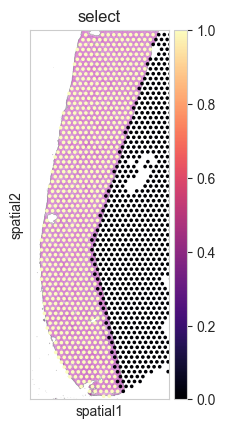

In [7]:
location = adata_st.obs.to_numpy()[:, 1:]
select_temp = np.logical_or(location[:, 0]*0.55+location[:, 1]<43, (55-location[:, 0])*0.35+location[:, 1]<23)
adata_st.obs['select'] = select_temp.astype(int)
# sc.pl.spatial(adata_st, cmap='magma', color='select', img=Xenium_background, scale_factor=1, size=1)
# sc.pl.spatial(adata_st, cmap='magma', color='select', img_key='hires_crop', size=1)
sc.pl.spatial(adata_st, cmap='magma', color='select', img_key='hires_crop', size=1, crop_coord=crop_coord)

In [9]:
proportion_truth_cortex = proportion_truth[adata_st.obs['select']==1]
proportion_estimated_cortex = [proportion[adata_st.obs['select']==1] for proportion in proportion_estimated]

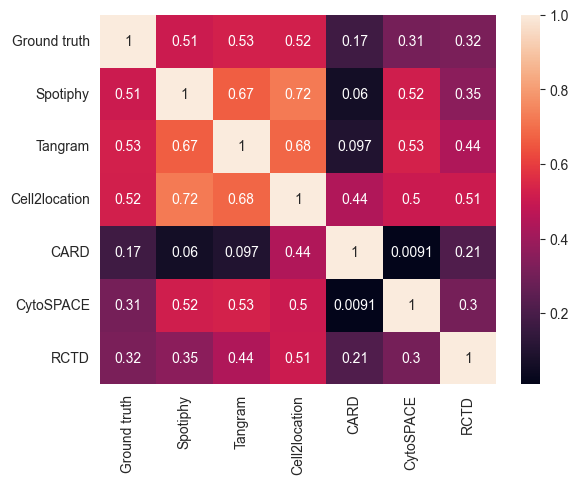

In [10]:
proportion_agg = [proportion_truth_cortex.flatten()+1e-10] + [proportion.flatten()+1e-10 for proportion in proportion_estimated_cortex]
proportion_agg = np.vstack(proportion_agg)
corr_matrix = np.corrcoef(proportion_agg)
plt.grid(False)
sns.heatmap(corr_matrix, xticklabels=['Ground truth']+methods, yticklabels=['Ground truth']+methods, annot=True)
plt.savefig(results_folder+'figures/correlation', dpi=400, bbox_inches = 'tight')

In [ ]:
for i, cell_type in enumerate(type_list):
    proportion_agg = [proportion_truth_cortex[:, i]+1e-10] + [proportion[:, i]+1e-10 for proportion in proportion_estimated_cortex]
    proportion_agg = np.vstack(proportion_agg)
    corr_matrix = np.corrcoef(proportion_agg)
    plt.figure(figsize=(7, 6))
    plt.grid(False)
    plt.title(cell_type)
    sns.heatmap(corr_matrix, xticklabels=['Ground truth']+methods, yticklabels=['Ground truth']+methods, annot=True)
    cell_type = "".join(x for x in cell_type if x.isalnum())
    plt.savefig(results_folder+'figures/correlation_'+cell_type+'.png', dpi=500, bbox_inches = 'tight')

distance.py (1288): invalid value encountered in true_divide
deconvolution.py (334): Passing `palette` without assigning `hue` is deprecated.


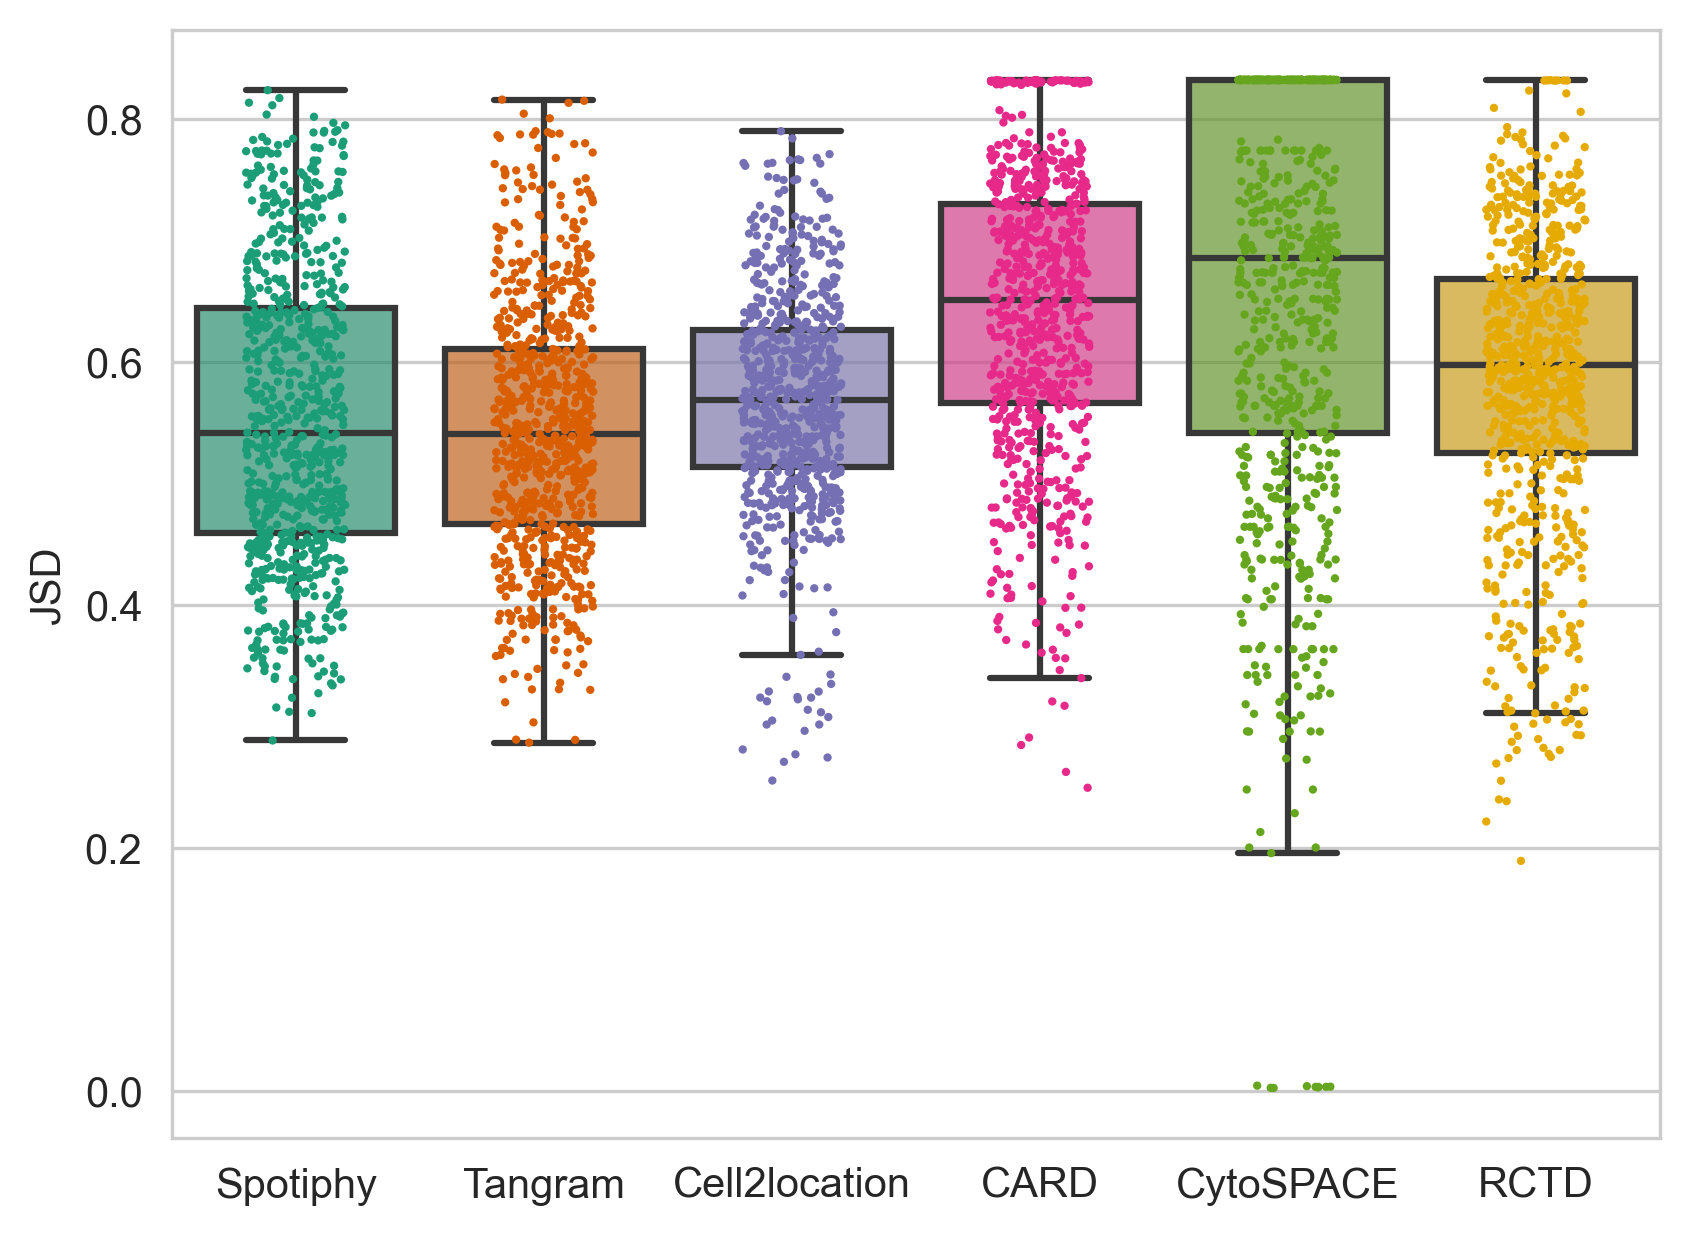

In [11]:
Eval = spotiphy.deconvolution.Evaluation(proportion_truth_cortex, proportion_estimated_cortex, methods, out_dir=results_folder)
Eval.plot_metric(save=True, metric='JSD')

In [ ]:
type_list_truth = [type +'_truth' for type in type_list]
adata_st.obs[type_list_truth] = proportion_truth
type_list_method = []
for method in methods:
    type_list_method.append([type +'_' + method for type in type_list])
    adata_st.obs[type_list_method[-1]] = proportion_dict[method]
adata_st_cut = adata_st[adata_st.obs['select']==1]

In [13]:
proportion_all = np.vstack(proportion_estimated_cortex)
vmax_uniform = np.quantile(proportion_all, 0.98, axis=0)

In [14]:
adata_st_cut.obsm['spatial'] = adata_st_cut.obsm['spatial'][:, [1, 0]]
adata_st_cut.uns['spatial']['NCF221-D']['images']['hires_crop'] = np.transpose(adata_st_cut.uns['spatial']['NCF221-D']['images']['hires_crop'], (1, 0, 2))
crop_coord = crop_coord[2:] + crop_coord[:2]
Xenium_background = np.transpose(Xenium_background, (1, 0, 2))

In [ ]:
idx = 5
vmax = np.quantile(adata_st_cut.obs[type_list_method[idx]].to_numpy(), 0.98, axis=0)
vmax[vmax < 1e-5] = 1e-5
with mpl.rc_context({'figure.figsize': [11, 4], 'figure.dpi': 500, 'axes.spines.bottom':False, 'axes.spines.left':False, 'axes.spines.right':False, 'axes.spines.top':False, 'axes.titlesize':'xx-small'}):
    ax = sc.pl.spatial(adata_st_cut, cmap='magma', color=type_list_method[idx], img_key='hires_crop', vmin=0, vmax=list(vmax_uniform), ncols=1, size=1.3, show=False, crop_coord=crop_coord, colorbar_loc=None, hspace=0.0, wspace=0, title=['']*len(type_list), )
    for ax_t in ax:
        ax_t.set_xlabel('')
        ax_t.set_ylabel('')
        ax_t.set_xticklabels([])
        ax_t.set_yticklabels([])
        plt.setp(ax_t.get_xticklabels(), visible=False)
        plt.setp(ax_t.get_yticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)
    ax[0].get_figure().savefig(results_folder+'figures/'+methods[idx]+'.jpg')

In [ ]:
vmax = np.quantile(adata_st_cut.obs[type_list_truth].to_numpy(), 0.98, axis=0)
vmax[vmax < 1e-5] = 1e-5
with mpl.rc_context({'figure.figsize': [11, 4], 'figure.dpi': 500, 'axes.spines.bottom':False, 'axes.spines.left':False, 'axes.spines.right':False, 'axes.spines.top':False, 'axes.titlesize':'xx-small'}):
    ax = sc.pl.spatial(adata_st_cut, cmap='magma', color=type_list_truth, img=Xenium_background, vmin=0, vmax=list(vmax_uniform), ncols=1, size=1.3, show=False, crop_coord=crop_coord, scale_factor=1, colorbar_loc=None, hspace=0.0, wspace=0, title=['']*len(type_list))
    for ax_t in ax:
        ax_t.set_xlabel('')
        ax_t.set_ylabel('')
        ax_t.set_xticklabels([])
        ax_t.set_yticklabels([])
        plt.setp(ax_t.get_xticklabels(), visible=False)
        plt.setp(ax_t.get_yticklabels(), visible=False)
    ax[0].get_figure().savefig(results_folder+'figures/truth.jpg')

In [1]:
# vmax = np.quantile(adata_st_cut.obs[type_list_truth].to_numpy(), 0.98, axis=0)
# vmax[vmax < 1e-5] = 1e-5
# with mpl.rc_context({'figure.figsize': [8, 4], 'figure.dpi': 500}):
#     ax = sc.pl.spatial(adata_st_cut, cmap='magma', color=type_list_truth, img=Xenium_background, vmin=0, vmax=list(vmax_uniform), ncols=5, size=1.3, show=False,
#                        crop_coord=crop_coord, scale_factor=1)
#     ax[0].get_figure().savefig(results_folder+'figures/truth.tiff')

In [ ]:
from matplotlib.ticker import MaxNLocator
for i, cell_type in enumerate(type_list):
    vmax = vmax_uniform[i]*100
    sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=0, vmax=vmax))
    sm._A = []
    fig, ax = plt.subplots()
    cb = fig.colorbar(sm)
    num_ticks = 4
    cb.locator = MaxNLocator(nbins=num_ticks)
    cb.update_ticks()
    cell_type = "".join(x for x in cell_type if x.isalnum())
    plt.title(cell_type)
    plt.savefig(results_folder+'figures/bar_'+cell_type+'.jpg', dpi=1000)

In [ ]:
imp.reload(spotiphy.deconvolution)
Eval = spotiphy.deconvolution.Evaluation(proportion_truth_cortex, proportion_estimated_cortex, methods, out_dir=results_folder,
                                         type_list=adata_st.uns['type_list'])
Eval.plot_metric_spot_type(save=True, metric='Absolute error')